In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Cargamos dataset
df_verificacion = pd.read_csv("Movimientos_limpios.csv", parse_dates=['fecha_operacion'])
display(df_verificacion.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes
1789,2024-01-23,Bizum De Debora Vega Ravelo Concepto Ropa Comp...,172.00,bizum de debora vega ravelo concepto ropa comp...,ingreso,2024-01
2257,2023-06-29,Bizum A Favor De Juan Ayoze Gonzalez Perez Con...,-446.08,bizum a favor de juan ayoze gonzalez perez con...,gasto,2023-06
1016,2024-12-24,"Compra Aliexpress, Luxembourg, Tarjeta 5489010...",-12.06,compra aliexpress luxembourg tarjeta comision,gasto,2024-12
1864,2023-12-26,Bizum De Debora Vega Ravelo Concepto Depresion,58.00,bizum de debora vega ravelo concepto depresion,ingreso,2023-12
1073,2024-12-02,Bizum A Favor De Fernando Lafuente Gonzalez Co...,-8.90,bizum a favor de fernando lafuente gonzalez co...,gasto,2024-12
1014,2024-12-26,"Pago Movil En Bk16212 Telde, Telde, Tarj. :*17...",-15.00,pago movil en bk telde telde tarj,gasto,2024-12
1425,2024-06-13,"Pago Movil En Hd Arnao, Telde, Tarj. :*179057",-10.65,pago movil en hd arnao telde tarj,gasto,2024-06
178,2022-02-03,"TRANSACCION CONTACTLESS EN LAIBA DONER KEB, TE...",-14.60,transaccion contactless en laiba doner keb tel...,gasto,2022-02
1764,2024-02-01,Recibo Sanitas S A De Seguros Nº Recibo 0049 6...,-65.97,recibo sanitas s a de seguros nº recibo bbfqmc...,gasto,2024-02
2211,2023-07-19,Bizum De Debora Vega Ravelo Concepto Colchón,17.50,bizum de debora vega ravelo concepto colchón,ingreso,2023-07


In [3]:
# Creamos copia para no dañar base original 
df_categorias = df_verificacion.copy()

# Clasificación


In [4]:
# Creamos funcion para crear las categorias y entrenar el modelo de categorización
def clasificar_por_reglas(texto):
    texto = str(texto).lower()

    # Ingresos
    if any(p in texto for p in ['transferencia inmediata de', 'transferencia de', 'transferencia recibida', 'reintegro']):
        return 'Ingreso'
    if 'bizum de' in texto:
        return 'Ingreso'

    # Cuentas pagadas / personales
    if 'bizum a' in texto or 'transferencia a' in texto or 'traspaso' in texto:
        return 'Transferencia personal'
    
    # Facturas
    if 'recibo' in texto or 'academia' in texto or 'univ' in texto:
        return 'Facturas'

    # Préstamos
    if 'liquidacion periodica' in texto:
        return 'Préstamo'
    
    # Compras no esenciales
    compras_no_esenciales = [
        'mediamarkt', 'media markt', 'fnac','ikea', 'leroy merlin', 'decathlon',
        'zara', 'shein', 'aliexpress', 'pull&bear', 'stradivarius', 'amazon', 'playstation',
        'viveros', 'zara home', 'idea market', 'playstation', 'tabaco', 'kiwoko',
        'primor', 'agroquimica', 'druni','kiwoko'
    ]
    if any(c in texto for c in compras_no_esenciales):
        return 'Compras no esenciales'

    # Restauración
    restaurantes = [
        'la sureña', 'goiko', 'vips', 'heladeria','pizza', 'hamburguesa','heladería', 'picoteo',
        'mcdonald', 'mc donald', 'burger king', 'burguer king', 'los charcones',
        'quinta cumbre', 'bk', 'camaleon', 'tagliatella', 'bar', 'cafeteria',
        'cafetería', 'food', 'tb metropo', 'compra uber', "llaollao", "compra sumup",
        'pasteleria', 'poke','las casitas', 'gelato', 'cantina', 'nothing', 'oakberry', 'restaurante'
    ]
    if any(r in texto for r in restaurantes):
        return 'Restauración'
    
    # Veterinario
    if 'el corral' in texto:
        return 'Facturas'

    # Supermercado
    supermercado = ['mercadona', 'aldi', 'lidl', 'hiperdino', 'carrefour', 'alcampo', 'farmacia']
    if any(s in texto for s in supermercado):
        return 'Supermercado'

    # Suscripciones / ocio
    ocio = ['netflix', 'spotify', 'hbo', 'disney+', 'disney plus', 'amazon prime', 'filmin', 'nintendo', 'game pass', 'cine', 'artesiete', 'apple com']
    if any(o in texto for o in ocio):
        return 'Ocio / Suscripciones'

    
    # Transporte público
    if any(p in texto for p in ['guaguas', 'salcai', 'global']):
        return 'Transporte'

    # Transporte privado / gasolina
    gasolina = ['repsol', 'cepsa', 'bp', 'shell', 'gasolinera', 'disa', 'parking', 'motor telde', 'coche', 'rueda', 'gasolina', 'petroprix']
    if any(g in texto for g in gasolina):
        return 'Transporte'


    return 'Sin categorizar'

df_categorias["categoria"] = df_categorias["operacion_limpia"].apply(clasificar_por_reglas)
display(df_categorias[df_categorias["categoria"] == "Sin categorizar"])

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
9,2021-09-25,"COMPRA PAGO M:VIL EN MCDONAL TRIANA, PALMAS (L...",-6.50,compra pago m vil en mcdonal triana palmas las...,gasto,2021-09,Sin categorizar
11,2021-09-26,"COMPRA PAGO M:VIL EN SPAR AMADORES, PUERTO RIC...",-4.77,compra pago m vil en spar amadores puerto rico...,gasto,2021-09,Sin categorizar
17,2021-09-28,"TRANSACCION CONTACTLESS EN HD C.C. ALISIOS, PA...",-1.99,transaccion contactless en hd c c alisios palm...,gasto,2021-09,Sin categorizar
19,2021-09-30,"COMPRA Altafit Vegueta GC, Las Palmas de, TARJ...",-9.90,compra altafit vegueta gc las palmas de tarjet...,gasto,2021-09,Sin categorizar
21,2021-10-04,"COMPRA PAGO M:VIL EN TACO BELL LAS A, LAS PALM...",-3.95,compra pago m vil en taco bell las a las palma...,gasto,2021-10,Sin categorizar
...,...,...,...,...,...,...,...
2329,2023-05-15,"Pago Movil En Minimarket La X, Las Palmas, Tar...",-0.85,pago movil en minimarket la x las palmas tarj,gasto,2023-05,Sin categorizar
2336,2023-05-11,"Pago Movil En Punto Coma, Palmas (las), Tarj. ...",-2.55,pago movil en punto coma palmas las tarj,gasto,2023-05,Sin categorizar
2342,2023-05-08,"Pago Movil En Shalom Restaura, Teror, Tarj. :*...",-7.90,pago movil en shalom restaura teror tarj,gasto,2023-05,Sin categorizar
2345,2023-05-08,"Pago Movil En Hd Melenara, Telde, Tarj. :*585729",-75.88,pago movil en hd melenara telde tarj,gasto,2023-05,Sin categorizar


# Preparación del Modelo

In [5]:
# 1 Preparar los datos seleccionando los clasificados
df_etiquetado = df_categorias[df_categorias['categoria'] != 'Sin categorizar'].copy()
display(df_etiquetado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria
139,2022-01-02,"COMPRA SpotifyES P18D4C01A2, Stockholm, TARJET...",-4.99,compra spotifyes pdca stockholm tarjeta comision,gasto,2022-01,Ocio / Suscripciones
377,2022-07-19,"TRANSFERENCIA DE DEBORA VEGA RAVELO, CONCEPTO ..",15.00,transferencia de debora vega ravelo concepto,ingreso,2022-07,Ingreso
313,2022-05-25,TRANSFERENCIA DE EVELYMAR ESPERANZA BASTIDAS R...,162.00,transferencia de evelymar esperanza bastidas r...,ingreso,2022-05,Ingreso
1432,2024-06-10,Bizum De Debora Vega Ravelo Concepto Compra Ce...,85.00,bizum de debora vega ravelo concepto compra ce...,ingreso,2024-06,Ingreso
1163,2024-10-21,Bizum A Favor De Debora Vega Ravelo Concepto: Luz,-70.00,bizum a favor de debora vega ravelo concepto luz,gasto,2024-10,Transferencia personal
1526,2024-04-29,"Pago Movil En Mercadona Las T, Telde, Tarj. :*...",-12.98,pago movil en mercadona las t telde tarj,gasto,2024-04,Supermercado
1921,2023-12-04,"Compra Sumup *kraken, Las Palmas, Tarjeta 5489...",-3.00,compra sumup kraken las palmas tarjeta comision,gasto,2023-12,Restauración
305,2022-05-12,"TRANSACCION CONTACTLESS EN LAS CASITAS EMP, LA...",-2.60,transaccion contactless en las casitas emp las...,gasto,2022-05,Restauración
2273,2023-06-19,Transferencia A Favor De Javier Concepto: Orla,-20.00,transferencia a favor de javier concepto orla,gasto,2023-06,Transferencia personal
1780,2024-01-29,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-20.00,compra internet en repsol waylet madrid tarj,gasto,2024-01,Transporte


In [6]:
# 2 Separar texto y etiquetas
x_texto = df_etiquetado['operacion_limpia']
y_etiqueta = df_etiquetado['categoria']

In [7]:
# 2. Guardar los textos en una lista para revisarlos luego
textos_originales = x_texto.tolist()

In [8]:
#3 Vectorizar el texto con TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)
X_vect = vectorizer.fit_transform(x_texto)

In [9]:
# 4. Entrenar el modelo
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test, x_text_train, x_text_test = train_test_split(
    X_vect, y_etiqueta, textos_originales, test_size=0.2, random_state=42
)

In [10]:
# 5. Crear el arbol de clasificación
from sklearn.ensemble import RandomForestClassifier

modelo= RandomForestClassifier()
modelo.fit(x_train, y_train)

RandomForestClassifier()

# Aplicación

Accuracy 0.9810725552050473
Reporte de clasificación:
                        precision    recall  f1-score   support

 Compras no esenciales       1.00      0.90      0.95        20
              Facturas       1.00      1.00      1.00        32
               Ingreso       1.00      1.00      1.00        61
  Ocio / Suscripciones       0.96      0.96      0.96        27
              Préstamo       1.00      1.00      1.00         4
          Restauración       0.92      0.98      0.95        55
          Supermercado       1.00      0.94      0.97        31
Transferencia personal       1.00      1.00      1.00        48
            Transporte       1.00      1.00      1.00        39

              accuracy                           0.98       317
             macro avg       0.99      0.98      0.98       317
          weighted avg       0.98      0.98      0.98       317



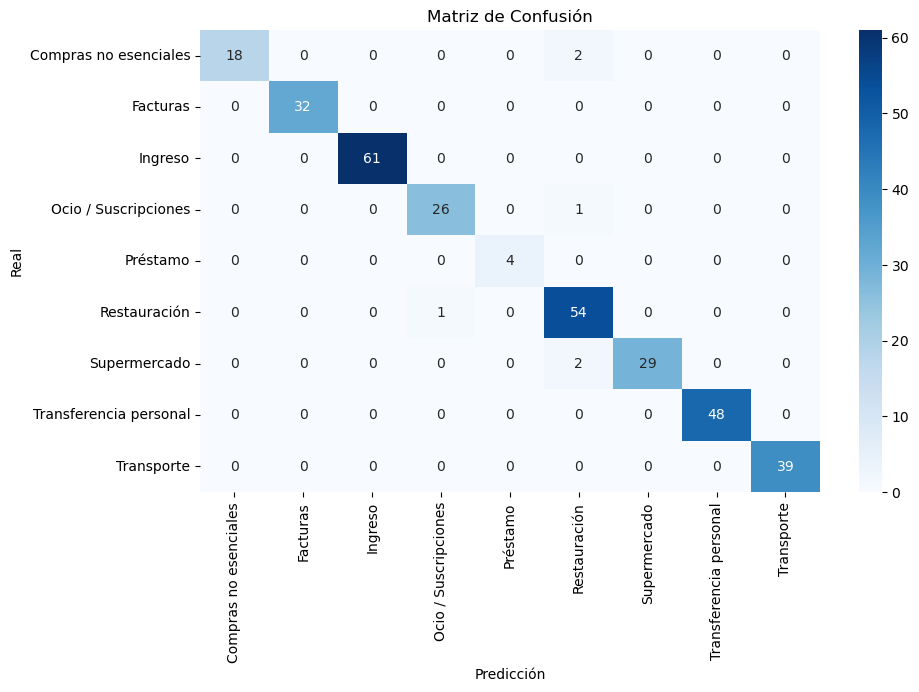

,texto,real,predicho
12,pago movil en druni s a palmas de gra tarj,Compras no esenciales,Restauración
40,pago movil en lefties zara rd telde tarj,Compras no esenciales,Restauración
138,pago movil en mercadona banad arucas tarj,Supermercado,Restauración
150,pago movil en llaollao hornos del re tarj,Restauración,Ocio / Suscripciones
173,transaccion contactless en carrefour lpalm pal...,Supermercado,Restauración
234,pago movil en yelmo cines ali palmas las tarj,Ocio / Suscripciones,Restauración


In [11]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predice sobre el conjunto de prueba
y_pred = modelo.predict(x_test)

# Exactitud global
print('Accuracy', accuracy_score(y_test, y_pred))

# Informe por clase
print('Reporte de clasificación:')
print(classification_report(y_test, y_pred))

# Matriz de confusión 
import seaborn as sns 

plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d',
            xticklabels=modelo.classes_, yticklabels=modelo.classes_, cmap='Blues')
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

# 7. Revisar predicciones incorrectas
errores = pd.DataFrame({
    'texto': x_text_test,
    'real': y_test.values,
    'predicho': y_pred
})
errores = errores[errores['real'] != errores['predicho']]

# Mostrar errores
display(errores.head(15))

# Categorizar los movimientos faltantes con el modelo

In [12]:
# Seleccionar solo los movimientos sin categoría
df_sin_etiquetar = df_categorias[df_categorias['categoria'] == 'Sin categorizar'].copy()


In [13]:
# Vectorizar esos nuevos textos con el vectorizer que ya tienes
x_nuevos = vectorizer.transform(df_sin_etiquetar['operacion_limpia'])

In [14]:
# predecir las categorías
df_sin_etiquetar['categoria_predicha'] = modelo.predict(x_nuevos)

In [15]:
# Ver los resultados
display(df_sin_etiquetar[['operacion_limpia', 'categoria_predicha']].sample(15))
df_sin_etiquetar.info()
df_sin_etiquetar[df_sin_etiquetar['categoria'] == 'Sin categorizar'].shape[0]

,operacion_limpia,categoria_predicha
1559,pago movil en rest chino feng san francisco tarj,Restauración
2186,compra internet en naviera armas s arrecife tarj,Transporte
747,pago movil en hd arnao telde tarj,Supermercado
1025,pago movil en cafe regina cc las palmas de tarj,Restauración
2038,pago movil en mgi telde telde tarj,Supermercado
2149,pago movil en hd melenara telde tarj,Supermercado
1486,pago movil en sagulpa parquim palmas de gra tarj,Compras no esenciales
181,transaccion contactless en supermercado hn pal...,Restauración
616,pago movil en llao llao palmas de gra tarj,Compras no esenciales
2267,pago movil en ella shoes las palmas de tarj,Supermercado


<class 'pandas.core.frame.DataFrame'>
Index: 781 entries, 9 to 2361
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   fecha_operacion     781 non-null    datetime64[ns]
 1   operacion           781 non-null    object        
 2   importe             781 non-null    float64       
 3   operacion_limpia    781 non-null    object        
 4   tipo                781 non-null    object        
 5   año_mes             781 non-null    object        
 6   categoria           781 non-null    object        
 7   categoria_predicha  781 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 54.9+ KB


781

In [16]:
# 4. Actualizar el DataFrame original usando índices
df_categorias.loc[df_sin_etiquetar.index, 'categoria'] = df_sin_etiquetar['categoria_predicha'].values

# 5. Añadir columna origen
df_categorias['origen'] = 'manual'
df_categorias.loc[df_sin_etiquetar.index, 'origen'] = 'modelo'
display(df_categorias.sample(15))
df_categorias[df_categorias['categoria'] == 'Sin categorizar'].shape[0]

df_categorias.info()

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
765,2023-03-28,"TRANSFERENCIA DE Evelymar Bastidas Rosario, CO...",162.00,transferencia de evelymar bastidas rosario con...,ingreso,2023-03,Ingreso,manual
2108,2023-08-30,Traspaso: Ahorro Hucha Objetivo: Regalo,-2.84,traspaso ahorro hucha objetivo regalo,gasto,2023-08,Transferencia personal,manual
12,2021-09-24,"COMPRA SpotifyES P171E66A14, Stockholm, TARJET...",-4.99,compra spotifyes pea stockholm tarjeta comision,gasto,2021-09,Ocio / Suscripciones,manual
1637,2024-03-18,Traspaso: Ahorro Hucha Objetivo: Regalo,-0.60,traspaso ahorro hucha objetivo regalo,gasto,2024-03,Transferencia personal,manual
223,2022-03-08,"TRANSACCION CONTACTLESS EN SUPERMERCDO LOP, VA...",-12.12,transaccion contactless en supermercdo lop val...,gasto,2022-03,Supermercado,modelo
864,2025-03-31,Bizum De Debora Vega Ravelo Concepto Todo Saldado,160.00,bizum de debora vega ravelo concepto todo saldado,ingreso,2025-03,Ingreso,manual
1157,2024-10-22,"Transferencia De Evelymar Bastidas Rosario, Co...",15.08,transferencia de evelymar bastidas rosario con...,ingreso,2024-10,Ingreso,manual
1527,2024-04-29,"Transferencia De Dius Madrid + Delegaciones, C...",1510.59,transferencia de dius madrid + delegaciones co...,ingreso,2024-04,Ingreso,manual
1040,2024-12-16,"Pago Movil En Dulceria San Ma, Vega De San M, ...",-12.70,pago movil en dulceria san ma vega de san m tarj,gasto,2024-12,Restauración,modelo
410,2022-08-03,"TRANSFERENCIA DE DEBORA VEGA RAVELO, CONCEPTO ..",33.10,transferencia de debora vega ravelo concepto,ingreso,2022-08,Ingreso,manual


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2362 entries, 0 to 2361
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   fecha_operacion   2362 non-null   datetime64[ns]
 1   operacion         2362 non-null   object        
 2   importe           2362 non-null   float64       
 3   operacion_limpia  2362 non-null   object        
 4   tipo              2362 non-null   object        
 5   año_mes           2362 non-null   object        
 6   categoria         2362 non-null   object        
 7   origen            2362 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 147.8+ KB


# Limpieza de los datos por categorías

In [17]:
df_categorizado= df_categorias.copy()
display(df_categorizado.sample(10))

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
1618,2024-03-22,"Compra Internet En Repsol Waylet, Madrid, Tarj...",-30.00,compra internet en repsol waylet madrid tarj,gasto,2024-03,Transporte,manual
2263,2023-06-26,"Pago Movil En Laiba Doner Keb, Telde, Tarj. :*...",-8.60,pago movil en laiba doner keb telde tarj,gasto,2023-06,Supermercado,modelo
699,2023-02-08,"PAGO MOVIL EN LAS CASITAS EMP, LAS PALMAS DE, ...",-1.10,pago movil en las casitas emp las palmas de tarj,gasto,2023-02,Restauración,manual
175,2022-02-01,RECIBO LAS PALMAS VEGUETA N: RECIBO 0049 6140 ...,-29.90,recibo las palmas vegueta n recibo bbdtlpb ref...,gasto,2022-02,Facturas,manual
1488,2024-05-13,"Pago Movil En Spar Bahia Feli, Juan Grande, Ta...",-11.54,pago movil en spar bahia feli juan grande tarj,gasto,2024-05,Restauración,modelo
2192,2023-07-27,"Pago Movil En Momenti Cc Las, Telde, Tarj. :*5...",-3.50,pago movil en momenti cc las telde tarj,gasto,2023-07,Restauración,modelo
2180,2023-07-31,"Compra Internet En Las Arenas Web, Las Palmas ...",-23.60,compra internet en las arenas web las palmas d...,gasto,2023-07,Transporte,modelo
2062,2023-10-16,"Pago Movil En Est. Texaco Los, Valsequillo (, ...",-2.40,pago movil en est texaco los valsequillo tarj,gasto,2023-10,Restauración,modelo
567,2022-11-21,"PAGO MOVIL EN BAZAR VALSEQUIL, VALSEQUILLO D, ...",-1.80,pago movil en bazar valsequil valsequillo d tarj,gasto,2022-11,Supermercado,modelo
438,2022-08-26,"PAGO MOVIL EN HD MELENARA, TELDE, TARJ. :*585729",-2.25,pago movil en hd melenara telde tarj,gasto,2022-08,Supermercado,modelo


<Axes: xlabel='categoria'>

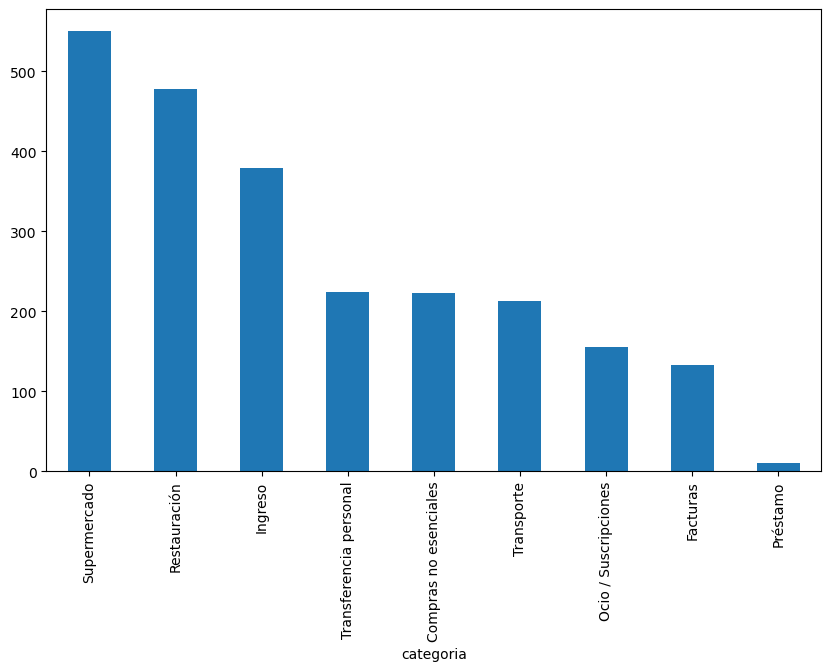

In [18]:
# Ubicamos por categoria
df_categorizado['categoria'].value_counts().plot(kind='bar', figsize=(10,6))

In [19]:
categoria = df_categorizado['categoria'].value_counts()
display(categoria)

categoria
Supermercado              550
Restauración              477
Ingreso                   379
Transferencia personal    224
Compras no esenciales     222
Transporte                213
Ocio / Suscripciones      155
Facturas                  132
Préstamo                   10
Name: count, dtype: int64

In [20]:
#  Pasamos los gastos a valores positivos
df_categorizado['importe'] = df_categorizado['importe'].abs()

In [21]:
#Analizamos los valores de préstamo
prestamo = df_categorizado[df_categorizado['categoria'] == 'Préstamo']
display(prestamo)

,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
373,2022-07-17,LIQUIDACION DEL CONTRATO 0003735 300,0.03,liquidacion del contrato,gasto,2022-07,Préstamo,modelo
862,2025-04-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-04,Préstamo,manual
912,2025-02-28,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-02,Préstamo,manual
951,2025-01-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-01,Préstamo,manual
1001,2024-12-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1077,2024-12-02,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
1132,2024-10-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1197,2024-10-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1478,2024-05-20,Liquidacion Del Contrato 0003735 300,0.02,liquidacion del contrato,gasto,2024-05,Préstamo,modelo
2361,2025-03-31,Prestamo,197.19,prestamo,ingreso,2025-03,Préstamo,modelo


In [22]:
resumen_categorias = df_categorizado.groupby('categoria')['importe'].agg(['count', 'sum', 'mean', 'min', 'max']).sort_values('sum', ascending=False)
display(resumen_categorias)

,count,sum,mean,min,max
categoria,,,,,
Ingreso,379,70043.16,184.810449,0.01,8000.00
Transferencia personal,224,24102.96,107.602500,0.02,10400.00
Supermercado,550,11259.36,20.471564,0.20,130.00
Facturas,132,9499.92,71.969091,1.00,342.35
Restauración,477,7346.79,15.402075,0.20,874.00
Compras no esenciales,222,7086.19,31.919775,0.20,797.03
Transporte,213,4616.54,21.673897,0.01,149.82
Ocio / Suscripciones,155,3562.14,22.981548,1.00,1430.05
Préstamo,10,1577.57,157.757000,0.02,197.19


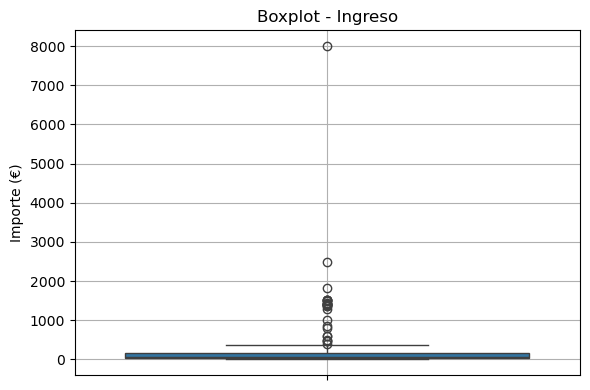

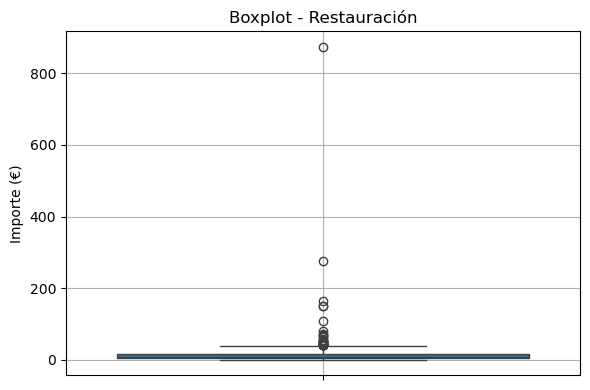

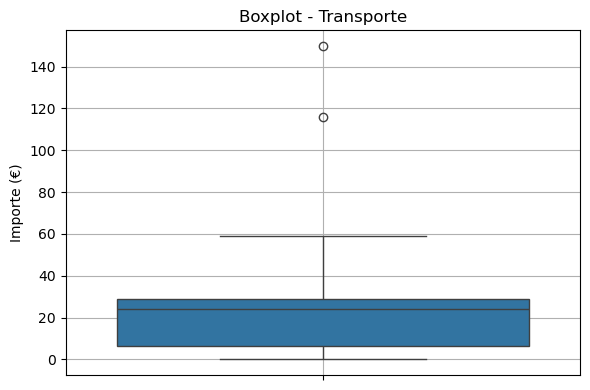

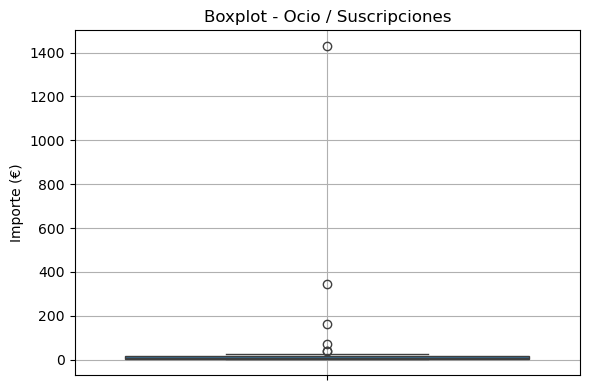

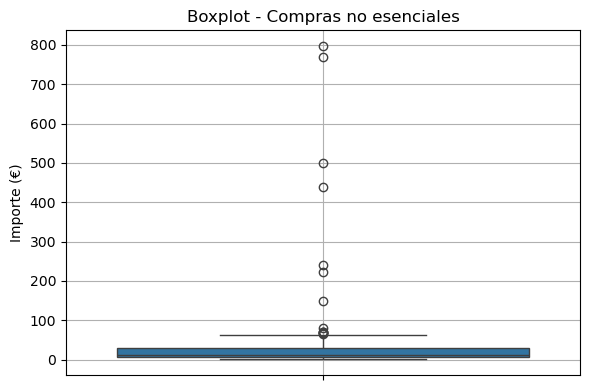

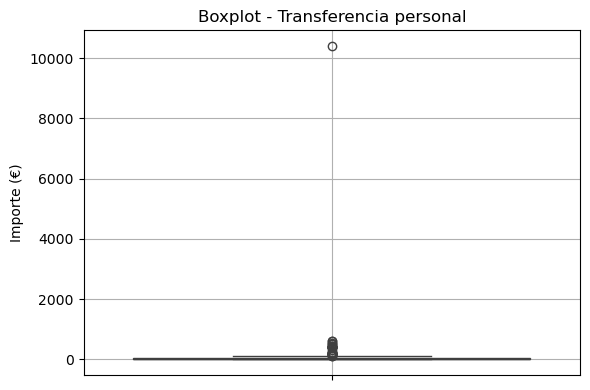

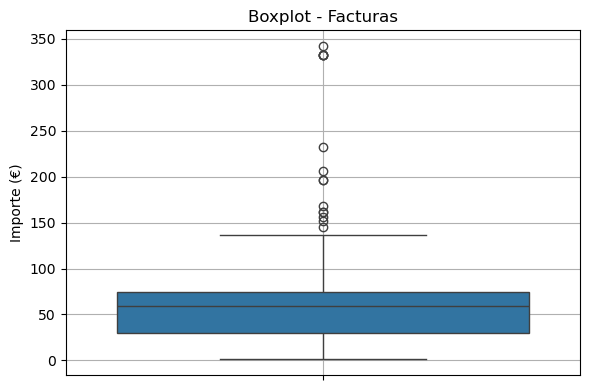

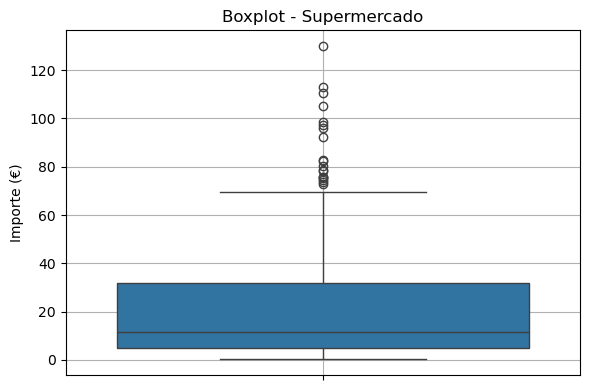

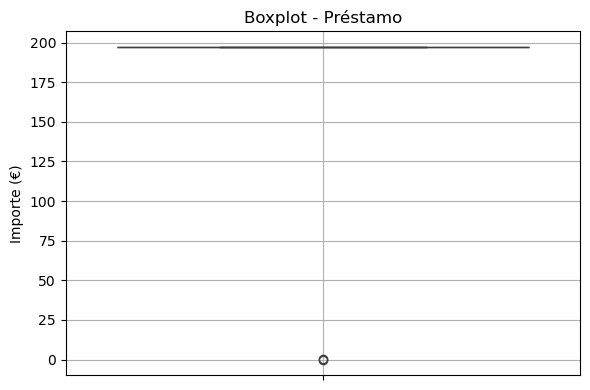

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [24]:
def mover_outliers_a_gastos_extra(df):
    df = df.copy()

    for cat in df['categoria'].unique():
        datos = df[df['categoria'] == cat]['importe']
        q1, q3 = datos.quantile([0.25, 0.9])
        iqr = q3 - q1
        bajo = q1 - 1.5 * iqr
        alto = q3 + 1.5 * iqr

        es_outlier = (df['categoria'] == cat) & ((df['importe'] < bajo) | (df['importe'] > alto))
        df.loc[es_outlier, 'categoria'] = 'Gastos extraordinarios'

    return df


In [25]:
df_categorizado = mover_outliers_a_gastos_extra(df_categorizado)
df_categorizado['categoria'].value_counts()


categoria
Supermercado              549
Restauración              469
Ingreso                   358
Transferencia personal    218
Compras no esenciales     215
Transporte                211
Ocio / Suscripciones      151
Facturas                  127
Gastos extraordinarios     56
Préstamo                    8
Name: count, dtype: int64

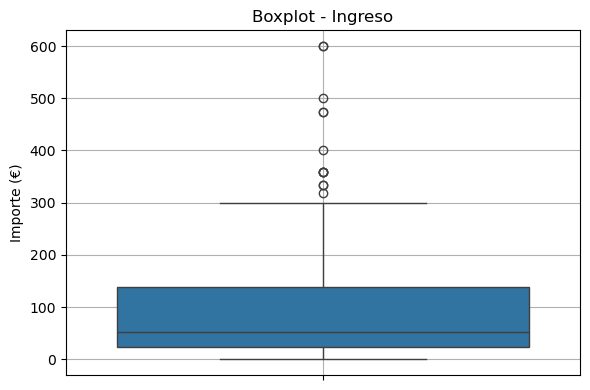

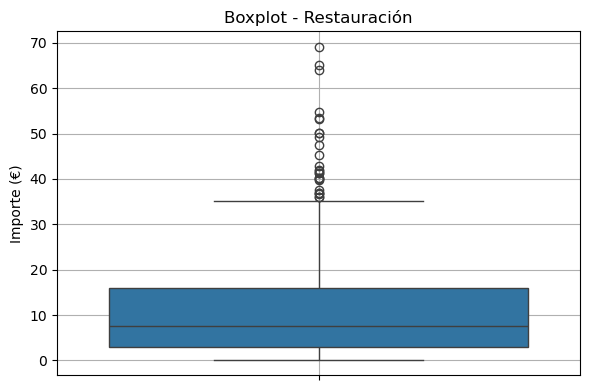

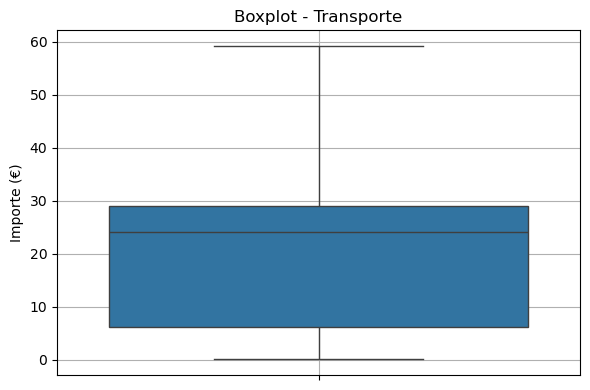

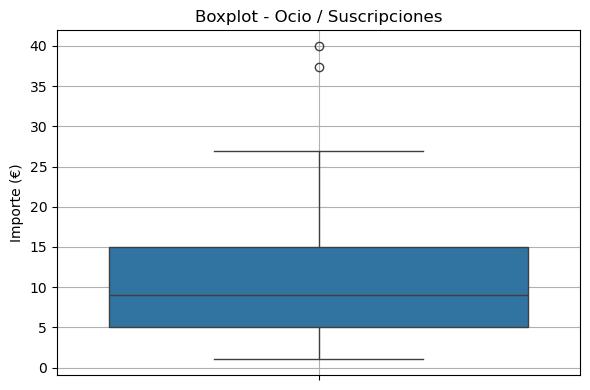

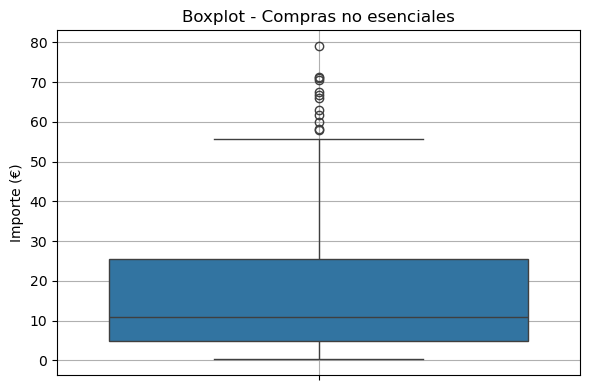

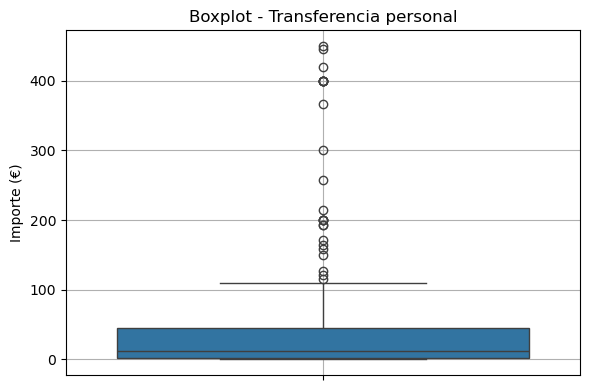

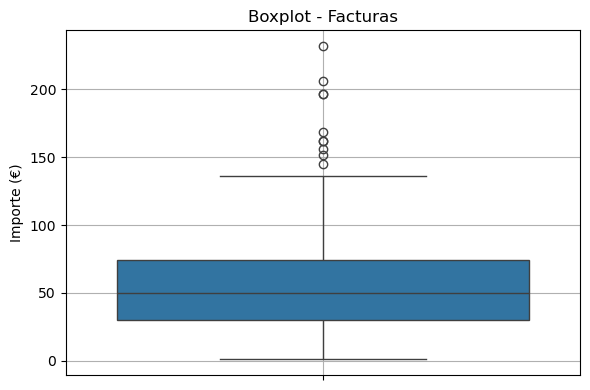

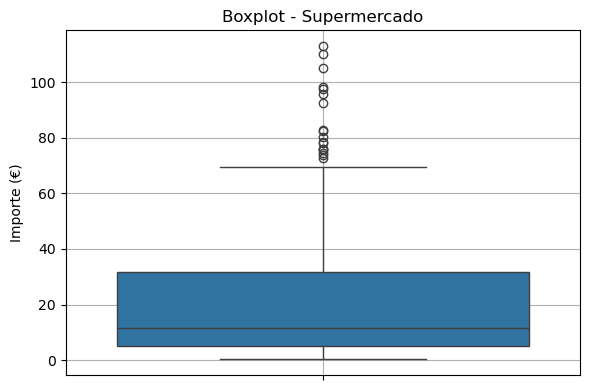

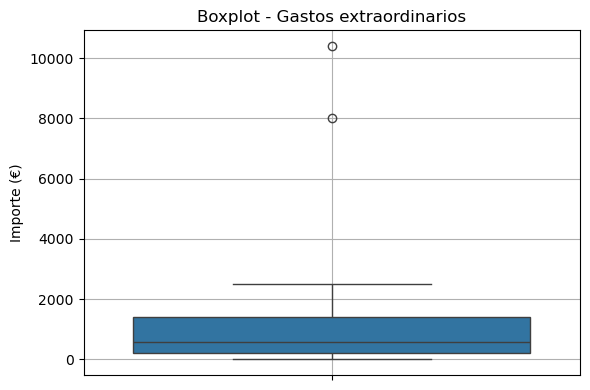

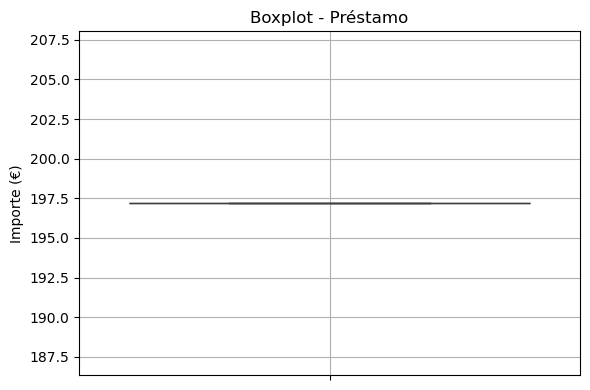

In [26]:
# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


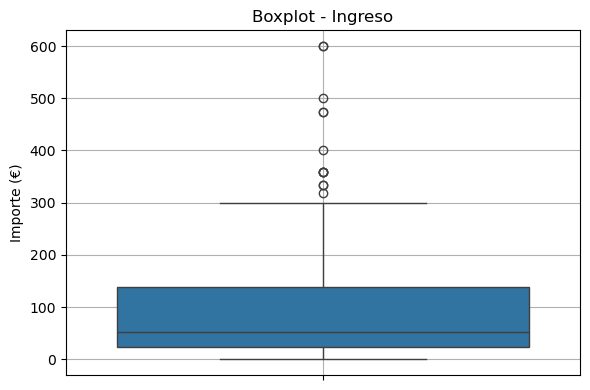

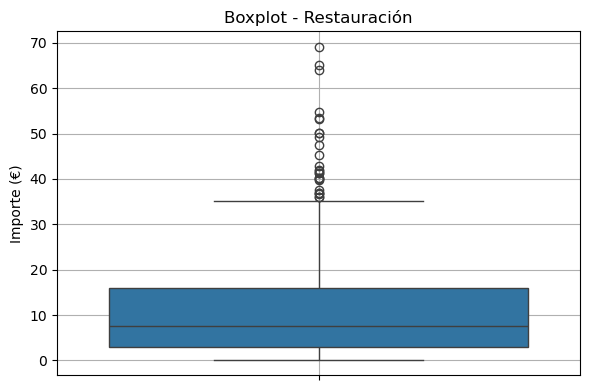

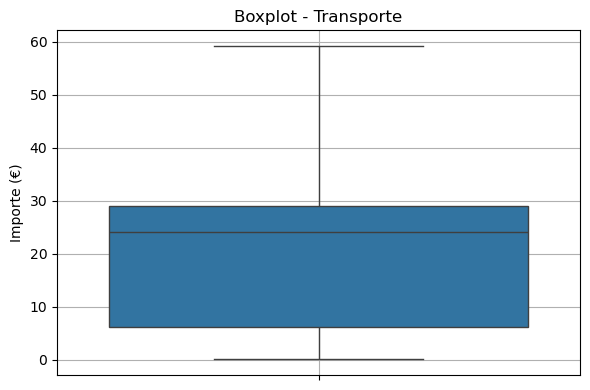

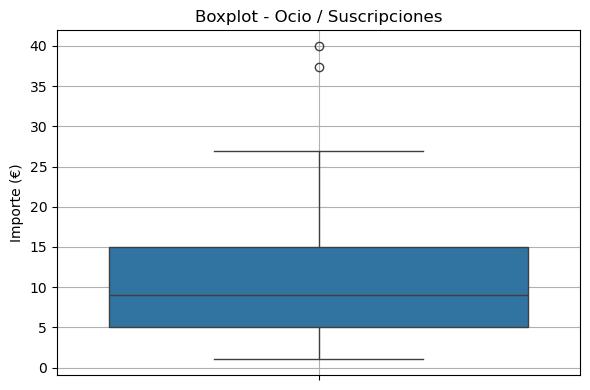

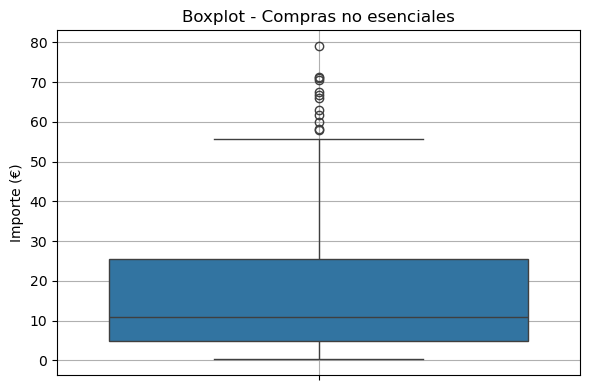

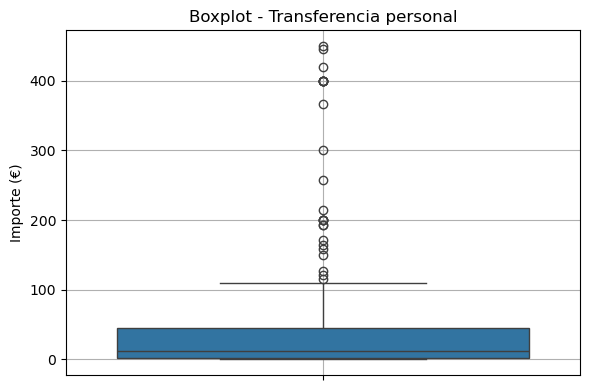

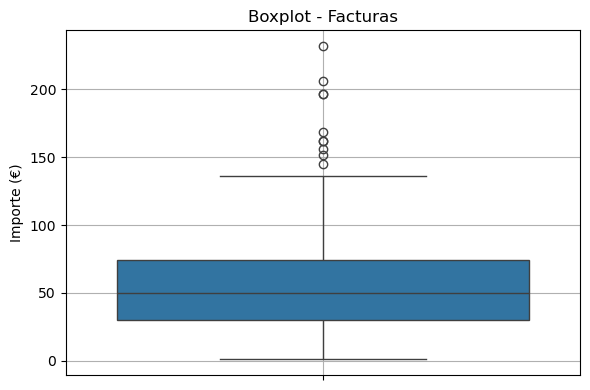

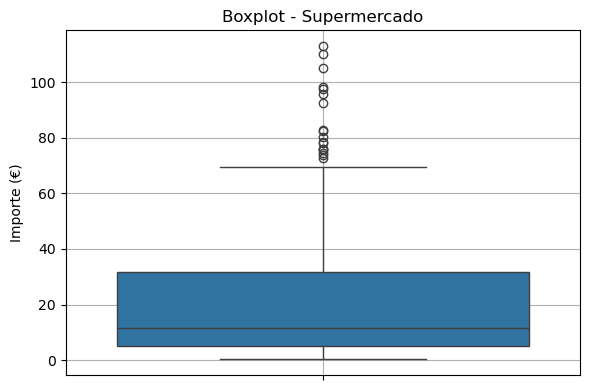

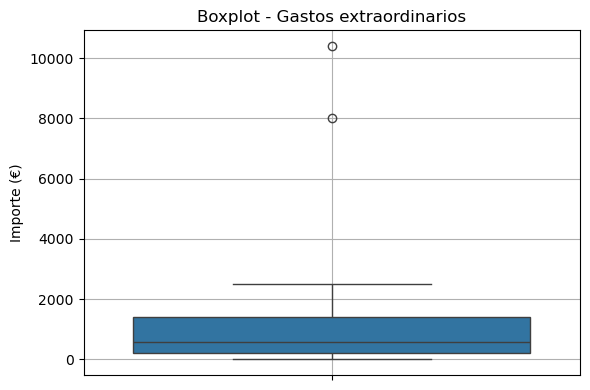

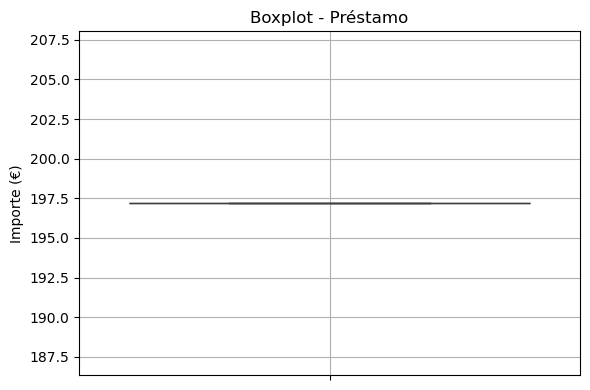

In [27]:
# Obtener las categorías únicas
categorias = df_categorizado['categoria'].unique()

# Crear un gráfico por categoría
for cat in categorias:
    plt.figure(figsize=(6, 4))
    datos = df_categorizado[df_categorizado['categoria'] == cat]

    sns.boxplot(data=datos, y='importe')
    plt.title(f'Boxplot - {cat}')
    plt.ylabel('Importe (€)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [31]:
df_categorizado[df_categorizado['categoria'] == 'Préstamo'].sample(8)



,fecha_operacion,operacion,importe,operacion_limpia,tipo,año_mes,categoria,origen
1132,2024-10-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual
1001,2024-12-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
951,2025-01-31,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-01,Préstamo,manual
2361,2025-03-31,Prestamo,197.19,prestamo,ingreso,2025-03,Préstamo,modelo
862,2025-04-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-04,Préstamo,manual
1077,2024-12-02,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-12,Préstamo,manual
912,2025-02-28,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2025-02,Préstamo,manual
1197,2024-10-01,Liquidacion Periodica Prestamo 0049 6140 143 0...,197.19,liquidacion periodica prestamo,gasto,2024-10,Préstamo,manual


In [29]:
# Guardar el CSV
df_categorizado.to_csv("Movimientos_categorizados.csv", index=False)